<a href="https://colab.research.google.com/github/vadhri/cuda-programming-notebook/blob/main/finite_diff_sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file contains a finite difference implementation of sine wave across different computations methods.
- Serial
- OpenMP ( parallelizing cores )
- MPI ( Distributed cluster - only 1 node )
- GPU

In order to check for accuracy of the results, FILE_WRITE need to be enabled along with the np.all() check in the cells.

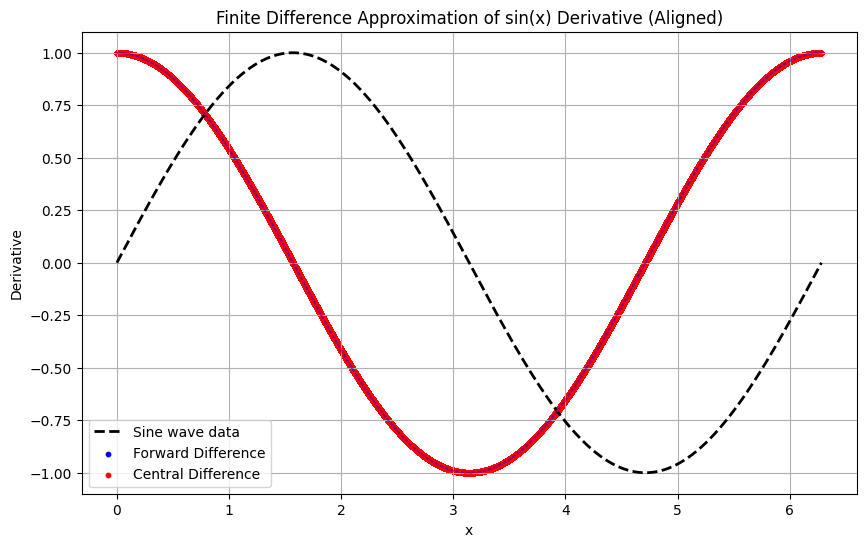

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate discrete sine wave data
x = np.linspace(0, 2 * np.pi, 100000)  # 100 discrete points
h = x[1] - x[0]  # Step size
y = np.sin(x)

# Step 2: Compute numerical derivatives using finite differences
forward_diff = (y[1:] - y[:-1]) / h  # Forward Difference
central_diff = (y[2:] - y[:-2]) / (2 * h)  # Central Difference

# Step 3: Define adjusted x-values for plotting derivatives
x_forward = x[:-1] + h/2  # Shift forward difference to the midpoint
x_central = x[1:-1]  # Central difference is already well-placed

# Step 4: Plot original sine function
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Sine wave data", color="black", linestyle="dashed", linewidth=2)

# Plot adjusted forward difference (shifted to correct position)
plt.scatter(x_forward, forward_diff, label="Forward Difference", color="blue", s=10)
plt.plot(x_forward, forward_diff, color="blue", alpha=0.5)

# Plot central difference at corresponding points
plt.scatter(x_central, central_diff, label="Central Difference", color="red", s=10)
plt.plot(x_central, central_diff, color="red", linestyle="dotted", alpha=0.8)

# Labels and title
plt.xlabel("x")
plt.ylabel("Derivative")
plt.legend()
plt.title("Finite Difference Approximation of sin(x) Derivative (Aligned)")
plt.grid()
plt.show()


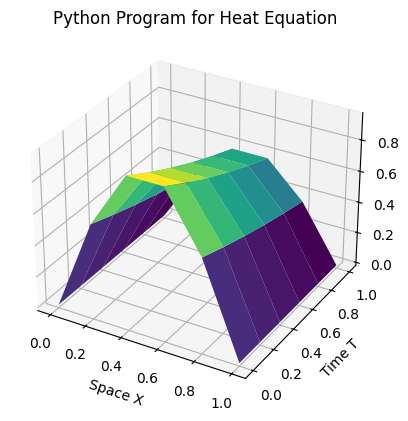

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1  # Length of rod
T = 1  # Maximum time bound
m = 5  # No. of intervals in space
n = 5  # No. of intervals in time
h = L / m  # Step size in space
k = T / n  # Step size in time
b = 0.05  # Coefficient of diffusivity
mu = k / h**2  # Check stability

# Initialization of solution
v = np.zeros((m + 1, n + 1))

# Initial condition
ic1 = lambda x: np.sin(np.pi * x)

# Space discretization
for j in range(1, m + 2):
    v[0, j - 1] = ic1((j - 1) * h)

# Boundary condition
b1 = lambda t: 0  # Left boundary condition
b2 = lambda t: 0  # Right boundary condition

# Time discretization
for i in range(1, n + 2):
    v[i - 1, 0] = b1((i - 1) * k)
    v[i - 1, n] = b2((i - 1) * k)

# Implementation of the scheme
for i in range(n):
    for j in range(1, m):
        v[i + 1, j] = (1 - 2 * b * mu) * v[i, j] + b * mu * v[i, j + 1] + b * mu * v[i, j - 1]

# Visualization
x = np.linspace(0, L, m + 1)
t = np.linspace(0, T, n + 1)
X, T = np.meshgrid(x, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, v, cmap='viridis')
ax.set_xlabel('Space X')
ax.set_ylabel('Time T')
ax.set_zlabel('V')
plt.title('Python Program for Heat Equation')
plt.show()

In [79]:
!apt-get update -yq
!apt-get install -yq libomp-dev

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists...
Building dependency tree...
Reading state informat

In [80]:
%%writefile finite_diff_sine_wave.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define PI 3.141592653589793

int main(int argc, char *argv[]) {
    // Check if N is provided
    if (argc < 2) {
        printf("Usage: %s <N>\n", argv[0]);
        return 1;
    }

    // Read N from command line
    int N = atoi(argv[1]);
    if (N < 3) {
        printf("Error: N must be at least 3.\n");
        return 1;
    }

    // Allocate memory dynamically
    double *x = (double *)malloc(N * sizeof(double));
    double *y = (double *)malloc(N * sizeof(double));
    double *forward_diff = (double *)malloc((N - 1) * sizeof(double));
    double *central_diff = (double *)malloc((N - 2) * sizeof(double));
    double *x_forward = (double *)malloc((N - 1) * sizeof(double));
    double *x_central = (double *)malloc((N - 2) * sizeof(double));

    if (!x || !y || !forward_diff || !central_diff || !x_forward || !x_central) {
        printf("Memory allocation failed.\n");
        return 1;
    }

    // Step 1: Generate discrete sine wave data
    double h = (2 * PI) / (N - 1);
    for (int i = 0; i < N; i++) {
        x[i] = i * h;
        y[i] = sin(x[i]);
    }

    // Step 2: Compute numerical derivatives using finite differences
    for (int i = 0; i < N - 1; i++) {
        forward_diff[i] = (y[i + 1] - y[i]) / h;
        x_forward[i] = x[i] + h / 2; // Adjusted x-values
    }

    for (int i = 0; i < N - 2; i++) {
        central_diff[i] = (y[i + 2] - y[i]) / (2 * h);
        x_central[i] = x[i + 1]; // Adjusted x-values
    }

    #ifdef FILE_WRITE
    FILE *file = fopen("output.txt", "w");
    if (file == NULL) {
        printf("Error opening file for writing.\n");
        return 1;
    }

    // Step 3: Write results to file using OpenMP
    for (int i = 0; i < N - 2; i++) {
        fprintf(file, "%.6f, %.6f, %.6f, %.6f\n", x[i], y[i], forward_diff[i], central_diff[i]);
    }

    // Close file
    fclose(file);
    #endif
    // Free allocated memory
    free(x);
    free(y);
    free(forward_diff);
    free(central_diff);
    free(x_forward);
    free(x_central);

    return 0;
}



Overwriting finite_diff_sine_wave.c


In [81]:
!gcc -fopenmp -o finite_diff_sine_wave finite_diff_sine_wave.c -lm
!time ./finite_diff_sine_wave 1000000
# data = np.loadtxt("output.txt", delimiter=",", skiprows=1)


real	0m0.056s
user	0m0.028s
sys	0m0.028s


In [82]:
%%writefile finite_diff_sine_wave_openmp.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define PI 3.141592653589793

int main(int argc, char *argv[]) {
    // Check if N is provided
    if (argc < 2) {
        printf("Usage: %s <N>\n", argv[0]);
        return 1;
    }

    // Read N from command line
    int N = atoi(argv[1]);
    if (N < 3) {
        printf("Error: N must be at least 3.\n");
        return 1;
    }

    // Allocate memory dynamically
    double *x = (double *)malloc(N * sizeof(double));
    double *y = (double *)malloc(N * sizeof(double));
    double *forward_diff = (double *)malloc((N - 1) * sizeof(double));
    double *central_diff = (double *)malloc((N - 2) * sizeof(double));
    double *x_forward = (double *)malloc((N - 1) * sizeof(double));
    double *x_central = (double *)malloc((N - 2) * sizeof(double));

    if (!x || !y || !forward_diff || !central_diff || !x_forward || !x_central) {
        printf("Memory allocation failed.\n");
        return 1;
    }

    // Step 1: Generate discrete sine wave data
    double h = (2 * PI) / (N - 1);

    #pragma omp parallel for
    for (int i = 0; i < N; i++) {
        x[i] = i * h;
        y[i] = sin(x[i]);
    }

    // Step 2: Compute numerical derivatives using finite differences
    #pragma omp parallel for
    for (int i = 0; i < N - 1; i++) {
        forward_diff[i] = (y[i + 1] - y[i]) / h;
        x_forward[i] = x[i] + h / 2; // Adjusted x-values
    }

    #pragma omp parallel for
    for (int i = 0; i < N - 2; i++) {
        central_diff[i] = (y[i + 2] - y[i]) / (2 * h);
        x_central[i] = x[i + 1]; // Adjusted x-values
    }

    #ifdef FILE_WRITE
    FILE *file = fopen("openmp_output.txt", "w");
    if (file == NULL) {
        printf("Error opening file for writing.\n");
        return 1;
    }

    // Step 3: Write results to file using OpenMP
    for (int i = 0; i < N - 2; i++) {
        fprintf(file, "%.6f, %.6f, %.6f, %.6f\n", x[i], y[i], forward_diff[i], central_diff[i]);
    }

    // Close file
    fclose(file);
    #endif

    // Free allocated memory
    free(x);
    free(y);
    free(forward_diff);
    free(central_diff);
    free(x_forward);
    free(x_central);

    return 0;
}



Overwriting finite_diff_sine_wave_openmp.c


In [83]:
!gcc -fopenmp -o finite_diff_sine_wave_openmp finite_diff_sine_wave_openmp.c -lm
!time ./finite_diff_sine_wave_openmp 100000
# data = np.loadtxt("openmp_output.txt", delimiter=",")
# np.all(np.isclose(forward_diff[:-1], data[:, 2], atol=0.0001))



real	0m0.007s
user	0m0.004s
sys	0m0.006s


In [84]:
!apt-get install -y mpich
!mpirun --version  # Check MPI installation


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
mpich is already the newest version (4.0-3).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
mpirun (Open MPI) 4.1.2

Report bugs to http://www.open-mpi.org/community/help/


In [85]:
%%writefile finite_diff_sine_wave_mpi.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <mpi.h>

#define PI 3.141592653589793

int main(int argc, char** argv) {
    int rank, size, N;

    // Initialize MPI
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    // Ensure command-line argument is provided
    if (argc < 2) {
        if (rank == 0) {
            printf("Usage: %s <N>\n", argv[0]);
        }
        MPI_Finalize();
        return 1;
    }

    // Read N from command line
    N = atoi(argv[1]);
    if (N < size) {
        if (rank == 0) {
            printf("Error: N must be greater than or equal to the number of processes.\n");
        }
        MPI_Finalize();
        return 1;
    }

    // Compute local workload
    int local_N = N / size;
    int remainder = N % size;
    int start = rank * local_N + (rank < remainder ? rank : remainder);
    int end = start + local_N + (rank < remainder ? 1 : 0);

    int local_size = end - start;
    double h = (2 * PI) / (N - 1);

    // Allocate local arrays
    double *x = (double *)malloc(local_size * sizeof(double));
    double *y = (double *)malloc(local_size * sizeof(double));
    double *forward_diff = (double *)malloc((local_size - 1) * sizeof(double));
    double *central_diff = (double *)malloc((local_size - 2) * sizeof(double));

    // Step 1: Generate discrete sine wave data
    for (int i = 0; i < local_size; i++) {
        x[i] = (start + i) * h;
        y[i] = sin(x[i]);
    }

    // Step 2: Compute numerical derivatives
    for (int i = 0; i < local_size - 1; i++) {
        forward_diff[i] = (y[i + 1] - y[i]) / h;
    }

    for (int i = 0; i < local_size - 2; i++) {
        central_diff[i] = (y[i + 2] - y[i]) / (2 * h);
    }

    // Allocate space for gathering results on rank 0
    double *full_x = NULL, *full_y = NULL, *full_forward = NULL, *full_central = NULL;
    if (rank == 0) {
        full_x = (double *)malloc(N * sizeof(double));
        full_y = (double *)malloc(N * sizeof(double));
        full_forward = (double *)malloc((N - 1) * sizeof(double));
        full_central = (double *)malloc((N - 2) * sizeof(double));
    }

    // Gather results from all processes
    MPI_Gather(x, local_size, MPI_DOUBLE, full_x, local_size, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    MPI_Gather(y, local_size, MPI_DOUBLE, full_y, local_size, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    MPI_Gather(forward_diff, local_size - 1, MPI_DOUBLE, full_forward, local_size - 1, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    MPI_Gather(central_diff, local_size - 2, MPI_DOUBLE, full_central, local_size - 2, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    // Save results to file (only rank 0 does this)

    if (rank == 0) {
        #ifdef FILE_WRITE
        FILE *file = fopen("mpi_output.txt", "w");
        if (file == NULL) {
            printf("Error opening file for writing.\n");
            MPI_Finalize();
            return 1;
        }
        for (int i = 0; i < N - 2; i++) {
            fprintf(file, "%.6f, %.6f, %.6f, %.6f\n", full_x[i], full_y[i], full_forward[i], full_central[i]);
        }
        fclose(file);
        printf("Results saved to mpi_output.txt\n");
        #endif

        // Free memory
        free(full_x);
        free(full_y);
        free(full_forward);
        free(full_central);
    }

    // Free allocated memory
    free(x);
    free(y);
    free(forward_diff);
    free(central_diff);

    MPI_Finalize();
    return 0;
}



Overwriting finite_diff_sine_wave_mpi.c


In [86]:
!mpicc finite_diff_sine_wave_mpi.c -o finite_diff_sine_wave_mpi -lm
!time mpirun --allow-run-as-root -np 1 ./finite_diff_sine_wave_mpi 100000
# data = np.loadtxt("mpi_output.txt", delimiter=",")
# np.all(np.isclose(forward_diff[:-1], data[:, 2], atol=0.0001))


real	0m0.327s
user	0m0.035s
sys	0m0.055s


In [87]:
%%writefile finite_diff_sine_wave_cuda.cu
#include <stdio.h>
#include <math.h>
#include <cuda_runtime.h>

#define PI 3.141592653589793

// CUDA Kernel to compute x values and sine wave y = sin(x)
__global__ void compute_sine_wave(double *x, double *y, double h, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N) {
        x[i] = i * h;
        y[i] = sin(x[i]);
    }
}

// CUDA Kernel to compute forward difference
__global__ void compute_forward_diff(double *y, double *forward_diff, double h, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N - 1) {
        forward_diff[i] = (y[i + 1] - y[i]) / h;
    }
}

// CUDA Kernel to compute central difference
__global__ void compute_central_diff(double *y, double *central_diff, double h, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N - 2) {
        central_diff[i] = (y[i + 2] - y[i]) / (2 * h);
    }
}

int main(int argc, char** argv) {
    if (argc != 2) {
        printf("Usage: %s <N>\n", argv[0]);
        return 1;
    }

    int N = atoi(argv[1]);
    double h = (2 * PI) / (N - 1);

    // Allocate GPU memory
    double *d_x, *d_y, *d_forward_diff, *d_central_diff;
    cudaMalloc(&d_x, N * sizeof(double));
    cudaMalloc(&d_y, N * sizeof(double));
    cudaMalloc(&d_forward_diff, (N - 1) * sizeof(double));
    cudaMalloc(&d_central_diff, (N - 2) * sizeof(double));

    // Define CUDA kernel launch parameters
    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;
    printf("threadsPerBlock : %d, blocksPerGrid = %d \n", threadsPerBlock, blocksPerGrid);

    // Launch CUDA kernels
    compute_sine_wave<<<blocksPerGrid, threadsPerBlock>>>(d_x, d_y, h, N);
    cudaDeviceSynchronize();

    compute_forward_diff<<<blocksPerGrid, threadsPerBlock>>>(d_y, d_forward_diff, h, N);
    cudaDeviceSynchronize();

    compute_central_diff<<<blocksPerGrid, threadsPerBlock>>>(d_y, d_central_diff, h, N);
    cudaDeviceSynchronize();

    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("CUDA error: %s\n", cudaGetErrorString(err));
    }


    // Allocate CPU memory
    double *x = (double*)malloc(N * sizeof(double));
    double *y = (double*)malloc(N * sizeof(double));
    double *forward_diff = (double*)malloc((N - 1) * sizeof(double));
    double *central_diff = (double*)malloc((N - 2) * sizeof(double));

    // Copy results back to CPU
    cudaMemcpy(x, d_x, N * sizeof(double), cudaMemcpyDeviceToHost);
    cudaMemcpy(y, d_y, N * sizeof(double), cudaMemcpyDeviceToHost);
    cudaMemcpy(forward_diff, d_forward_diff, (N - 1) * sizeof(double), cudaMemcpyDeviceToHost);
    cudaMemcpy(central_diff, d_central_diff, (N - 2) * sizeof(double), cudaMemcpyDeviceToHost);

    // Check if data is correctly copied
    printf("Sample Check:\n");
    printf("x[0] = %f, y[0] = %f, forward_diff[0] = %f, central_diff[0] = %f\n",
           x[0], y[0], forward_diff[0], central_diff[0]);

    // Save to file
    #ifdef FILE_WRITE
    FILE *file = fopen("cuda_output.txt", "w");
    for (int i = 0; i < N - 2; i++) {
        fprintf(file, "%.12f, %.12f, %.12f, %.12f\n", x[i], y[i], forward_diff[i], central_diff[i]);
    }
    fclose(file);
    #endif

    // Free GPU and CPU memory
    cudaFree(d_x);
    cudaFree(d_y);
    cudaFree(d_forward_diff);
    cudaFree(d_central_diff);
    free(x);
    free(y);
    free(forward_diff);
    free(central_diff);

    printf("Computation finished! Results saved to cuda_output.txt\n");
    return 0;
}


Overwriting finite_diff_sine_wave_cuda.cu


In [88]:
# !nvcc --version  # Check NVCC version
# !nvidia-smi       # Check CUDA driver version

# !nvcc -o finite_diff_sine_wave_cuda finite_diff_sine_wave_cuda.cu -lm

!nvcc -arch=sm_75 -gencode arch=compute_75,code=sm_75 finite_diff_sine_wave_cuda.cu -o finite_diff_sine_wave_cuda
!./finite_diff_sine_wave_cuda 100000

# data = np.loadtxt("cuda_output.txt", delimiter=",")
# np.all(np.isclose(forward_diff[:-1], data[:, 2], atol=0.001))


threadsPerBlock : 256, blocksPerGrid = 391 
Sample Check:
x[0] = 0.000000, y[0] = 0.000000, forward_diff[0] = 1.000000, central_diff[0] = 1.000000
Computation finished! Results saved to cuda_output.txt


Error running finite_diff_sine_wave: Command '['./finite_diff_sine_wave', '1000000000']' died with <Signals.SIGKILL: 9>.
Error running finite_diff_sine_wave_openmp: Command '['./finite_diff_sine_wave_openmp', '1000000000']' died with <Signals.SIGKILL: 9>.
Error running finite_diff_sine_wave_mpi: Command '['mpirun', '--allow-run-as-root', '-np', '1', './finite_diff_sine_wave_mpi', '1000000000']' returned non-zero exit status 137.


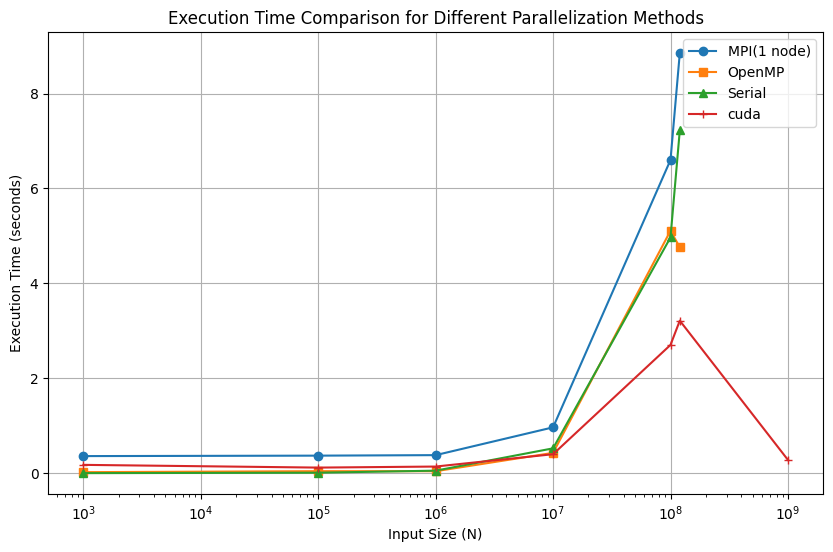

In [89]:
import subprocess
import time
import matplotlib.pyplot as plt
import numpy as np

def run_program(program, n_value):
    start_time = time.time()
    try:
        if program == "finite_diff_sine_wave_mpi":
          subprocess.run(["mpirun", "--allow-run-as-root", "-np", "1", "./finite_diff_sine_wave_mpi", str(n_value)], check=True, capture_output=True, text=True)
        elif program == "finite_diff_sine_wave_openmp":
          subprocess.run(["./finite_diff_sine_wave_openmp", str(n_value)], check=True, capture_output=True, text=True)
        elif program == "finite_diff_sine_wave_cuda":
          subprocess.run(["./finite_diff_sine_wave_cuda", str(n_value)], check=True, capture_output=True, text=True)
        else:
          subprocess.run(["./finite_diff_sine_wave", str(n_value)], check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        print(f"Error running {program}: {e}")
        return None
    end_time = time.time()
    return end_time - start_time

# N values to test
n_values = [1000, 100000, 1000000, 10000000, 100000000, 120000000, 1000000000]

# Store execution times
execution_times_mpi = []
execution_times_openmp = []
execution_times_serial = []
execution_times_cuda = []

# Run experiments
for n in n_values:
    serial_time = run_program("finite_diff_sine_wave", n)
    openmp_time = run_program("finite_diff_sine_wave_openmp", n)
    mpi_time = run_program("finite_diff_sine_wave_mpi", n)
    cuda_time = run_program("finite_diff_sine_wave_cuda", n)

    execution_times_mpi.append(mpi_time)
    execution_times_openmp.append(openmp_time)
    execution_times_serial.append(serial_time)
    execution_times_cuda.append(cuda_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_values, execution_times_mpi, label="MPI(1 node)", marker='o')
plt.plot(n_values, execution_times_openmp, label="OpenMP", marker='s')
plt.plot(n_values, execution_times_serial, label="Serial", marker='^')
plt.plot(n_values, execution_times_cuda, label="cuda", marker='+')

plt.xlabel("Input Size (N)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time Comparison for Different Parallelization Methods")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()
